In [46]:
from pylab import rcParams
from xgboost import XGBClassifier
rcParams['figure.figsize'] = 10, 5
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix,classification_report,accuracy_score

In [47]:
data= pd.read_csv('../data.csv')
data.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Current Credit Balance,Maximum Open Credit,Term_Short Term,Years in current job_10+ years,Years in current job_2 years,...,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_Own Home,Home Ownership_Rent,Loan Status
0,445412.0,709.0,1167493.0,5214.74,17.2,228190.0,416746.0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,99999999.0,741.0,2231892.0,29200.53,14.9,297996.0,750090.0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2,347666.0,721.0,806949.0,8741.90,12.0,256329.0,386958.0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,206602.0,7290.0,896857.0,16367.74,17.3,215308.0,272448.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,217646.0,730.0,1184194.0,10855.08,19.6,122170.0,272052.0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [48]:
data.dtypes

Current Loan Amount               float64
Credit Score                      float64
Annual Income                     float64
Monthly Debt                      float64
Years of Credit History           float64
Current Credit Balance            float64
Maximum Open Credit               float64
Term_Short Term                     int64
Years in current job_10+ years      int64
Years in current job_2 years        int64
Years in current job_3 years        int64
Years in current job_4 years        int64
Years in current job_5 years        int64
Years in current job_6 years        int64
Years in current job_7 years        int64
Years in current job_8 years        int64
Years in current job_9 years        int64
Years in current job_< 1 year       int64
Home Ownership_Own Home             int64
Home Ownership_Rent                 int64
Loan Status                         int64
dtype: object

In [49]:
##copying data
data1=data.copy()

### spliting data en X et Y

In [50]:
X= data1.drop('Loan Status', axis=1)
Y= data1['Loan Status']

### spliting the data to train and test

In [51]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 123)

### XGBoost

In [52]:
## converting Y_train & X_test & Y_train & Y_test to numpy array pour XGBoost
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [53]:
xgb= XGBClassifier()
params= {
        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13,14],
        'n_estimators' : [100, 300, 500, 800]
        }

##accuracy
grid_search_acc= GridSearchCV(estimator=xgb, param_grid= params, scoring='accuracy',cv=5, n_jobs=-1)
grid_search_acc= grid_search_acc.fit(X_train, Y_train)
y_predict= grid_search_acc.best_estimator_.predict(X_test)

----------
best parameters:  {'max_depth': 10, 'n_estimators': 500}
----------
[[12449  2910]
 [ 1278 14129]]
----------
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     15359
           1       0.83      0.92      0.87     15407

    accuracy                           0.86     30766
   macro avg       0.87      0.86      0.86     30766
weighted avg       0.87      0.86      0.86     30766

----------


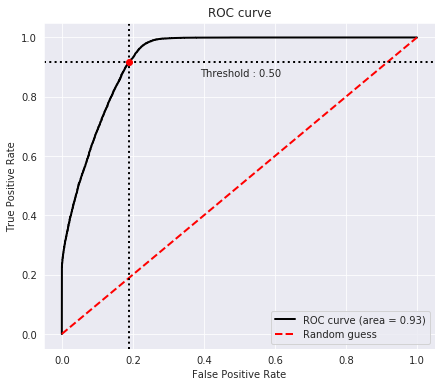

In [54]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_acc.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

##ROC
y_predict_proba = grid_search_acc.best_estimator_.predict_proba(X_test)[:,1]

# Visualisation with plot_metric
bc = BinaryClassification(Y_test, y_predict_proba, labels=[1, 0])
# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.title('ROC curve')
plt.show()

In [55]:
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=xgb, param_grid= params, scoring=rec_avg,cv=4, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, Y_train)
y_predict= grid_search_rec.best_estimator_.predict(X_test)

In [56]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_rec.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'max_depth': 12, 'n_estimators': 500}
----------
[[12428  2931]
 [ 1256 14151]]
----------
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     15359
           1       0.83      0.92      0.87     15407

    accuracy                           0.86     30766
   macro avg       0.87      0.86      0.86     30766
weighted avg       0.87      0.86      0.86     30766

----------


In [57]:
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=xgb, param_grid= params, scoring=prec_avg,cv=4, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, Y_train)
y_predict= grid_search_prec_avg.best_estimator_.predict(X_test)

In [58]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_prec_avg.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'max_depth': 12, 'n_estimators': 300}
----------
[[12422  2937]
 [ 1265 14142]]
----------
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     15359
           1       0.83      0.92      0.87     15407

    accuracy                           0.86     30766
   macro avg       0.87      0.86      0.86     30766
weighted avg       0.87      0.86      0.86     30766

----------


In [69]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2))
    scores_mean= scores_mean.T
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.set_ylim([0.845,0.867])
        ax.plot(grid_param_1[:-1], scores_mean[idx,:-1], '-o', label= name_param_2 + ': ' + str(val))
        #ax.plot(19, scores_mean[idx, -1:], '*', label= 'crt' + '=' + str(val) + ' & mx_dpt=None')
        
    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

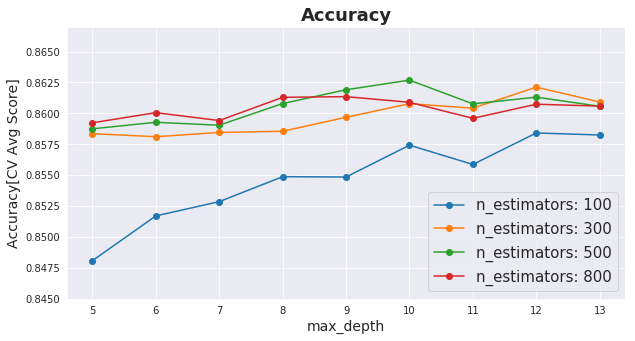

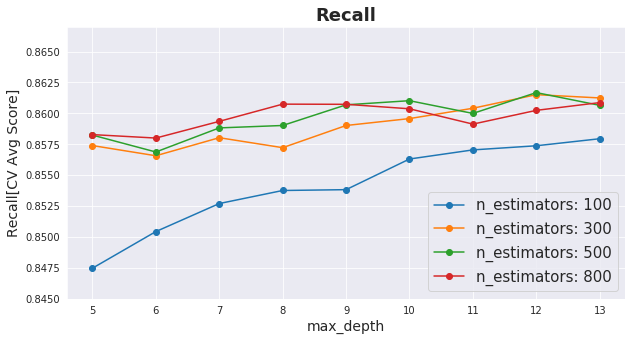

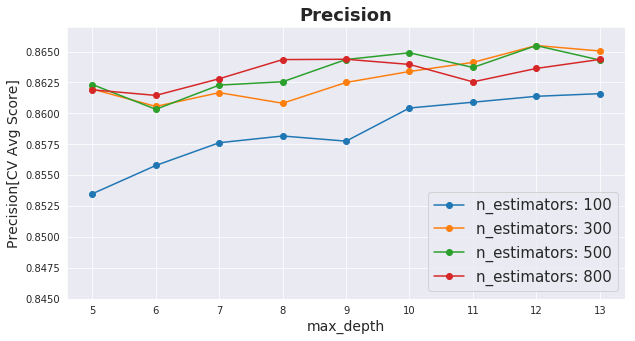

In [70]:
# Calling Method 
plot_grid_search(grid_search_acc.cv_results_, params['max_depth'], params['n_estimators'],  'max_depth', 'n_estimators', 'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['max_depth'], params['n_estimators'],  'max_depth', 'n_estimators', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['max_depth'], params['n_estimators'], 'max_depth', 'n_estimators', 'Precision')


In [61]:
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['n_estimators'], params['max_depth'])

In [71]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],},
                 index=index)

writer = pd.ExcelWriter('../tables_smote.xlsx')
df.to_excel(writer, 'XGB_smote')
writer.save()
writer.close()

In [64]:
df

,Accuracy,Precision(Avg),Recall(Avg)
"[100, 5]",0.848076,0.853494,0.847465
"[100, 6]",0.858357,0.861963,0.857392
"[100, 7]",0.858747,0.862328,0.858239
"[100, 8]",0.859234,0.861903,0.858279
"[100, 9]",0.851698,0.855782,0.850430
"[100, 10]",0.858106,0.860560,0.856567
"[100, 11]",0.859276,0.860328,0.856871
"[100, 12]",0.860056,0.861452,0.858000
"[100, 13]",0.852854,0.857623,0.852699
"[100, 14]",0.858454,0.861675,0.858028
